In [6]:
from pathlib import Path
import os
import sys
from collections import Counter

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.signal import correlate
from scipy.interpolate import interp1d
import xarray as xr

path_mod = f"{Path(os.path.dirname(os.path.realpath(''))).parents[0]}/"
sys.path.append(path_mod)

from src.indicators.flooding.glofas import utils, glofas

mpl.rcParams['figure.dpi'] = 300

In [31]:
DATA_DIR = Path(os.environ["AA_DATA_DIR"]) 
GLOFAS_DIR = DATA_DIR / "public/exploration/npl/glofas"
GLOFAS_RP_FILENAME = GLOFAS_DIR / "glofas_return_period_values.xlsx"
DHM_DIR = DATA_DIR / 'private/exploration/npl/dhm'
WL_PROCESSED_DIR = DHM_DIR / 'processed'
WL_OUTPUT_FILENAME = 'waterl_level_procssed.csv'
STATION_INFO_FILENAME = 'npl_dhm_station_info.xlsx'

COUNTRY_ISO3 = 'npl'

RP_LIST = [2, 3, 5] 
LEVEL_TYPES = ['warning', 'danger']

STATIONS = {
    'Koshi': ['Chatara', 'Simle', 'Majhitar', 'Kampughat'],
    'Karnali': ['Chisapani', 'Asaraghat', 'Dipayal', 'Samajhighat'],
    'Rapti': ['Kusum'],
    'Bagmati': ['Rai_goan'],
    'Babai': ['Chepang']
}

DURATION = 1

#### Define functions to make overlay plots

We want to understand what happens at Station B when Station A triggers according to a given threshold. 

In [108]:
def make_max_rp_hist(ax, hist_vals, n_bins, title, xlab):
    ax.hist(hist_vals, bins=n_bins)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.axvline(1, c='red', ls='--')
    ax.set_xlim([0, 2])
    return ax

def visualize_station_overlay(
    da_primary, 
    da_secondary, 
    val_event, 
    val_secondary, 
    duration, 
    plt_title, 
    hist_title, 
    save_title, 
    save=False):

    groups = utils.get_groups_above_threshold(da_primary.values, val_event, duration)
    if len(groups) == 0:
        print('There are no events captured at this  threshold')
        return
    
    max_post = []
    max_during = []
    max_pre = []

    ngroups = len(groups)
    nrows = 2
    ncols = round(ngroups/nrows)
    igroup = 1

    fig, axs = plt.subplots(nrows, ncols, figsize=(15,5), squeeze=False, sharey=True)
    fig.suptitle(plt_title)

    for i in range(nrows):

        for j in range(ncols):

            try:
                group = groups[igroup-1]
                
                # Values extend 15 days on either side of trigger event and normalize by the rp val
                da_event_buffer = da_secondary[group[0]-15: (group[-1]+15)] / val_secondary
                # Values just for the trigger event
                da_event = da_secondary[group[0]: group[-1]+1]
                # Keep track of the max value for each stage of the event
                max_post.append(max(da_event_buffer[-15:-1].values))
                max_during.append(max(da_event_buffer[15:-15].values))
                max_pre.append(max(da_event_buffer[0:15].values))


                ax = axs[i,j]
                ax.axes.xaxis.set_ticks([])
                ax.set_ylim([0, 1.5])

                trigger_start_formatted = pd.to_datetime(da_event[0].time.values).date()
                trigger_end_formatted = pd.to_datetime(da_event[-1].time.values).date()
                ax.set_title(f'{trigger_start_formatted} - {trigger_end_formatted}', fontsize=8)
                ax.fill_between(x=da_event.time, y1=0, y2=1.5,alpha=0.25)

                ax.hlines(y=1, xmin=da_event_buffer.time[0], xmax=da_event_buffer.time[-1], lw=1, ls='--')
                ax.plot(da_event_buffer.time, da_event_buffer, c='red', lw=1, alpha=1)
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)

            # In case we have too many subplots defined
            except:
                fig.delaxes(axs[i,j])

            igroup+=1

    fig.tight_layout()

    if save:
        plt.savefig(f'C:/Users/Hannah/Desktop/discharge_{save_title}.png')

    # Make the histograms of max % of RP reached
    n_bins = 5
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
    hist_vals = [max_pre, max_during, max_post]
    hist_titles = ['15 Days Before Trigger Period', 'During Trigger Period', '15 Days After Trigger Period']
    
    for iax, ax in enumerate(axs): 
        ax = make_max_rp_hist(ax, hist_vals[iax], n_bins, hist_titles[iax], hist_title)         
    
    if save:
        plt.savefig(f'C:/Users/Hannah/Desktop/max_hist_{save_title}.png')

#### Investigate relationship between stations with GloFAS water discharge

In [20]:
ds_glofas_reanalysis = utils.get_glofas_reanalysis(
    country_iso3=COUNTRY_ISO3)
df_return_period = utils.get_return_periods(ds_glofas_reanalysis, RP_LIST)
df_return_period_glofas = pd.read_excel(GLOFAS_RP_FILENAME)

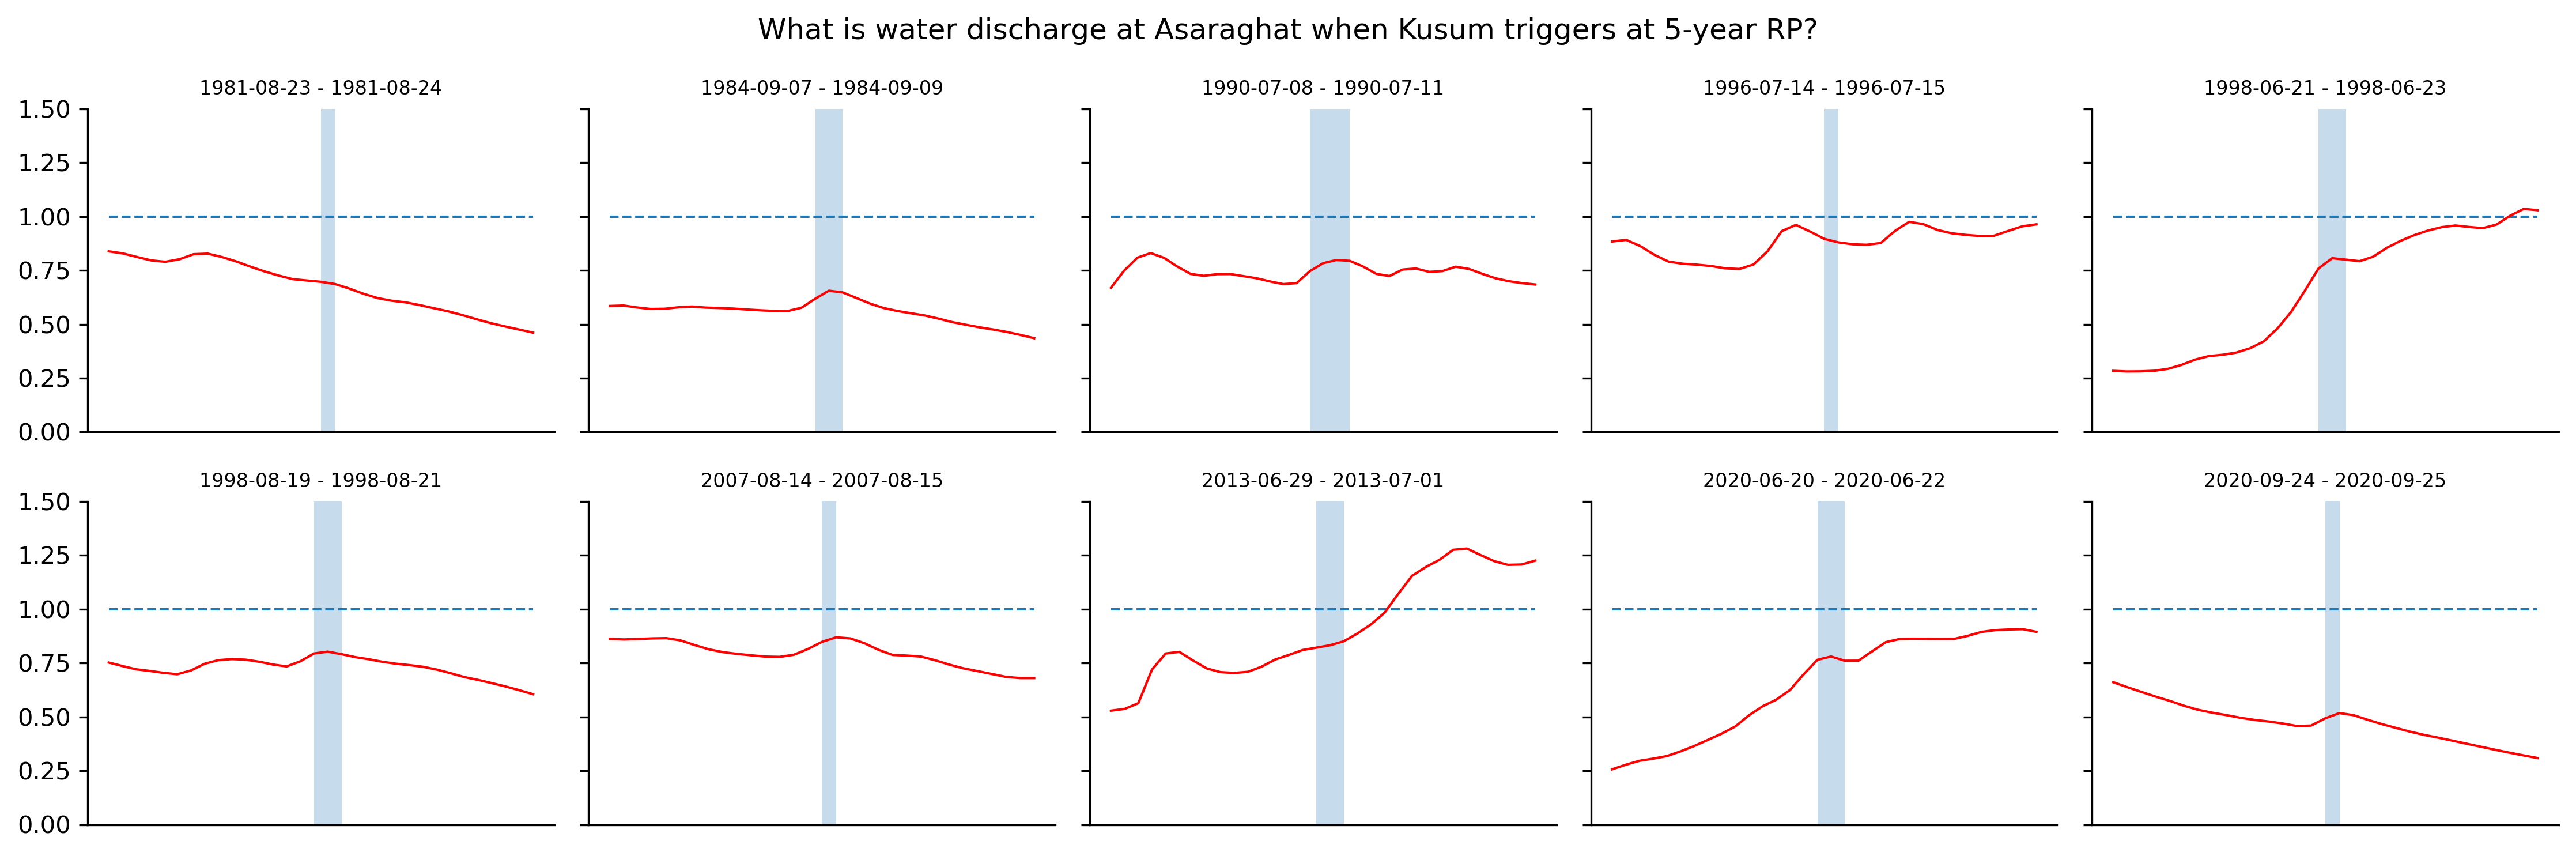

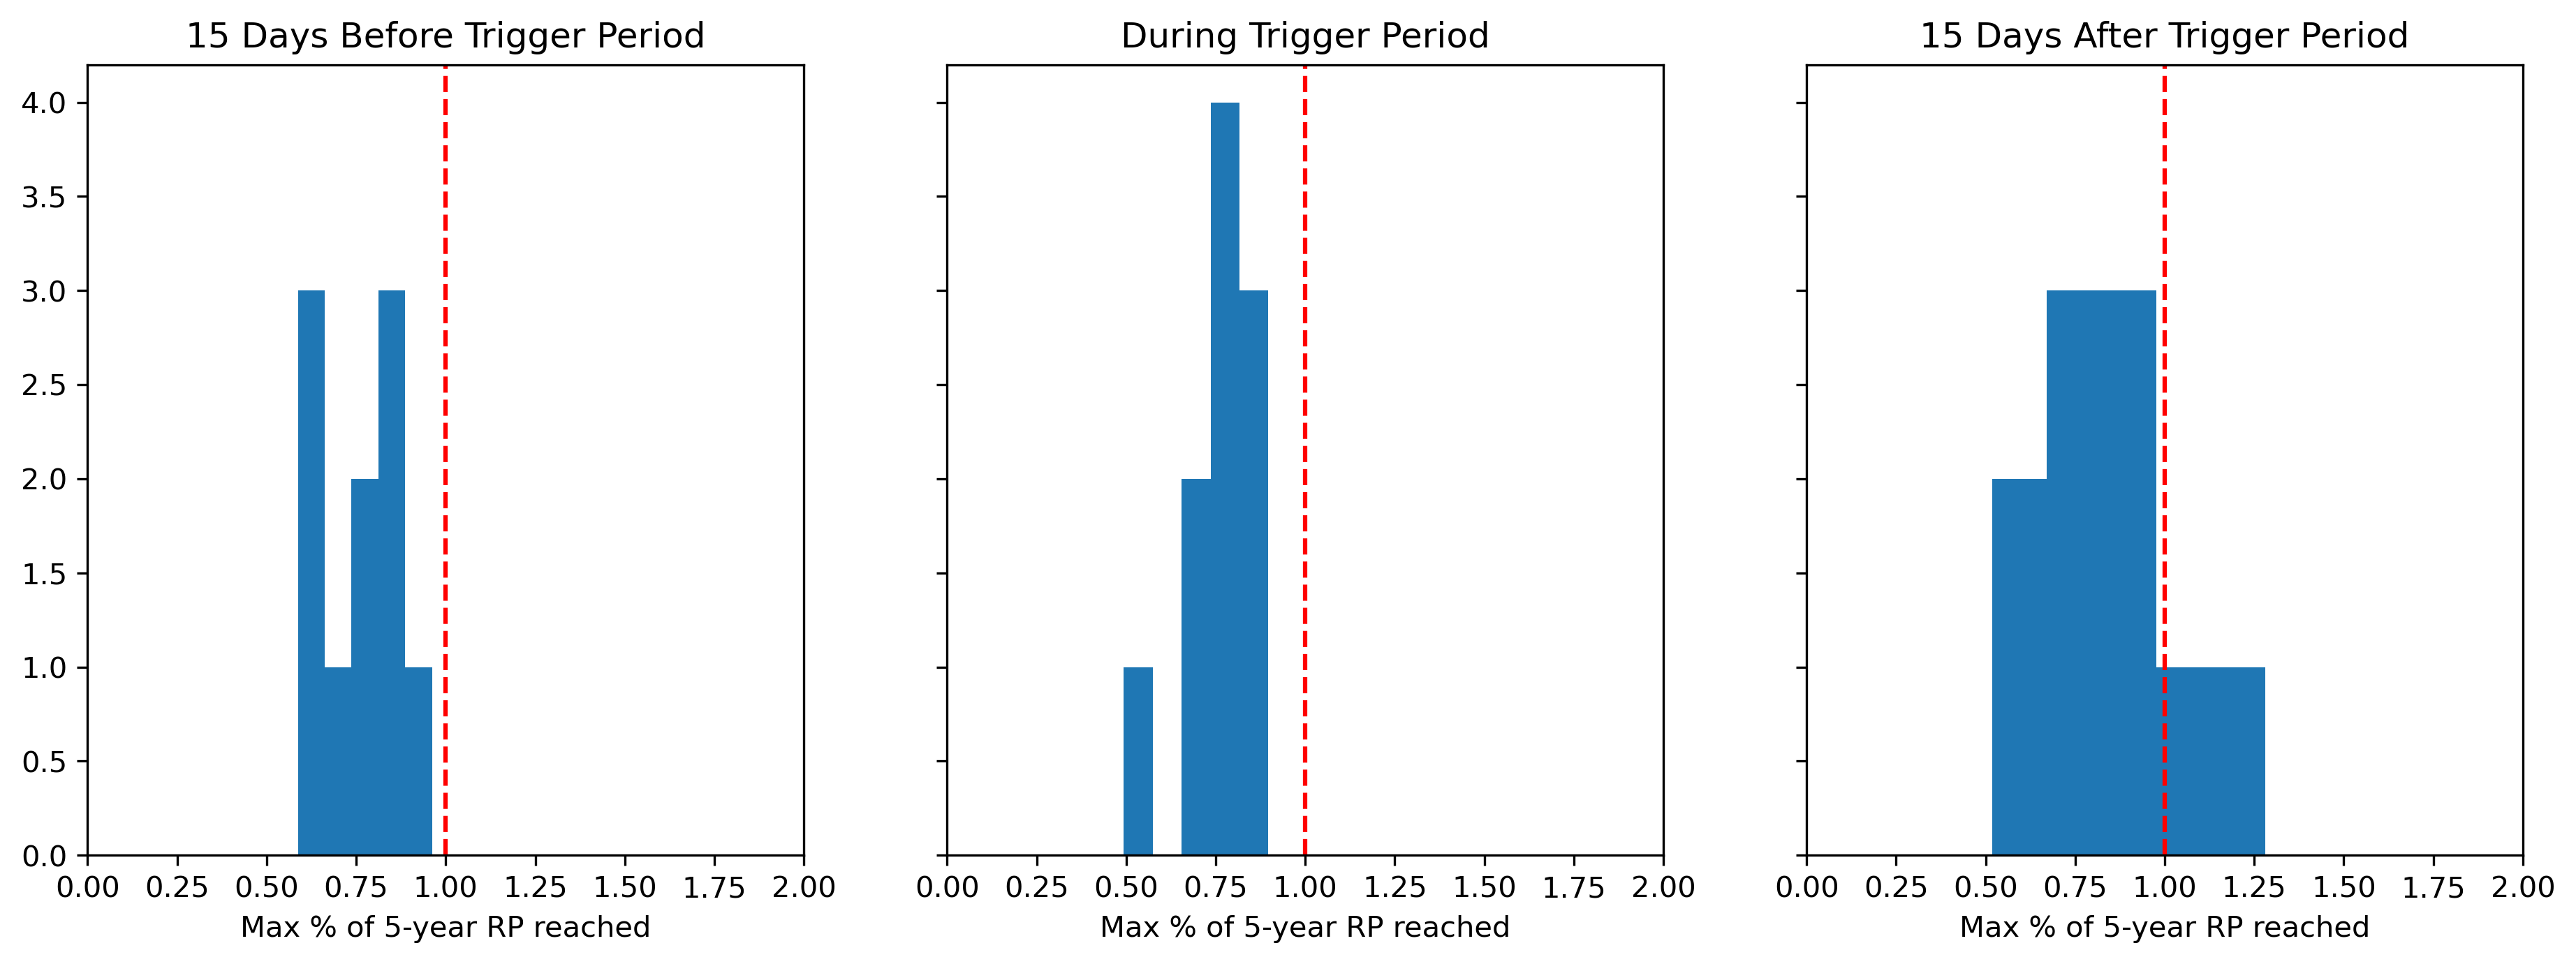

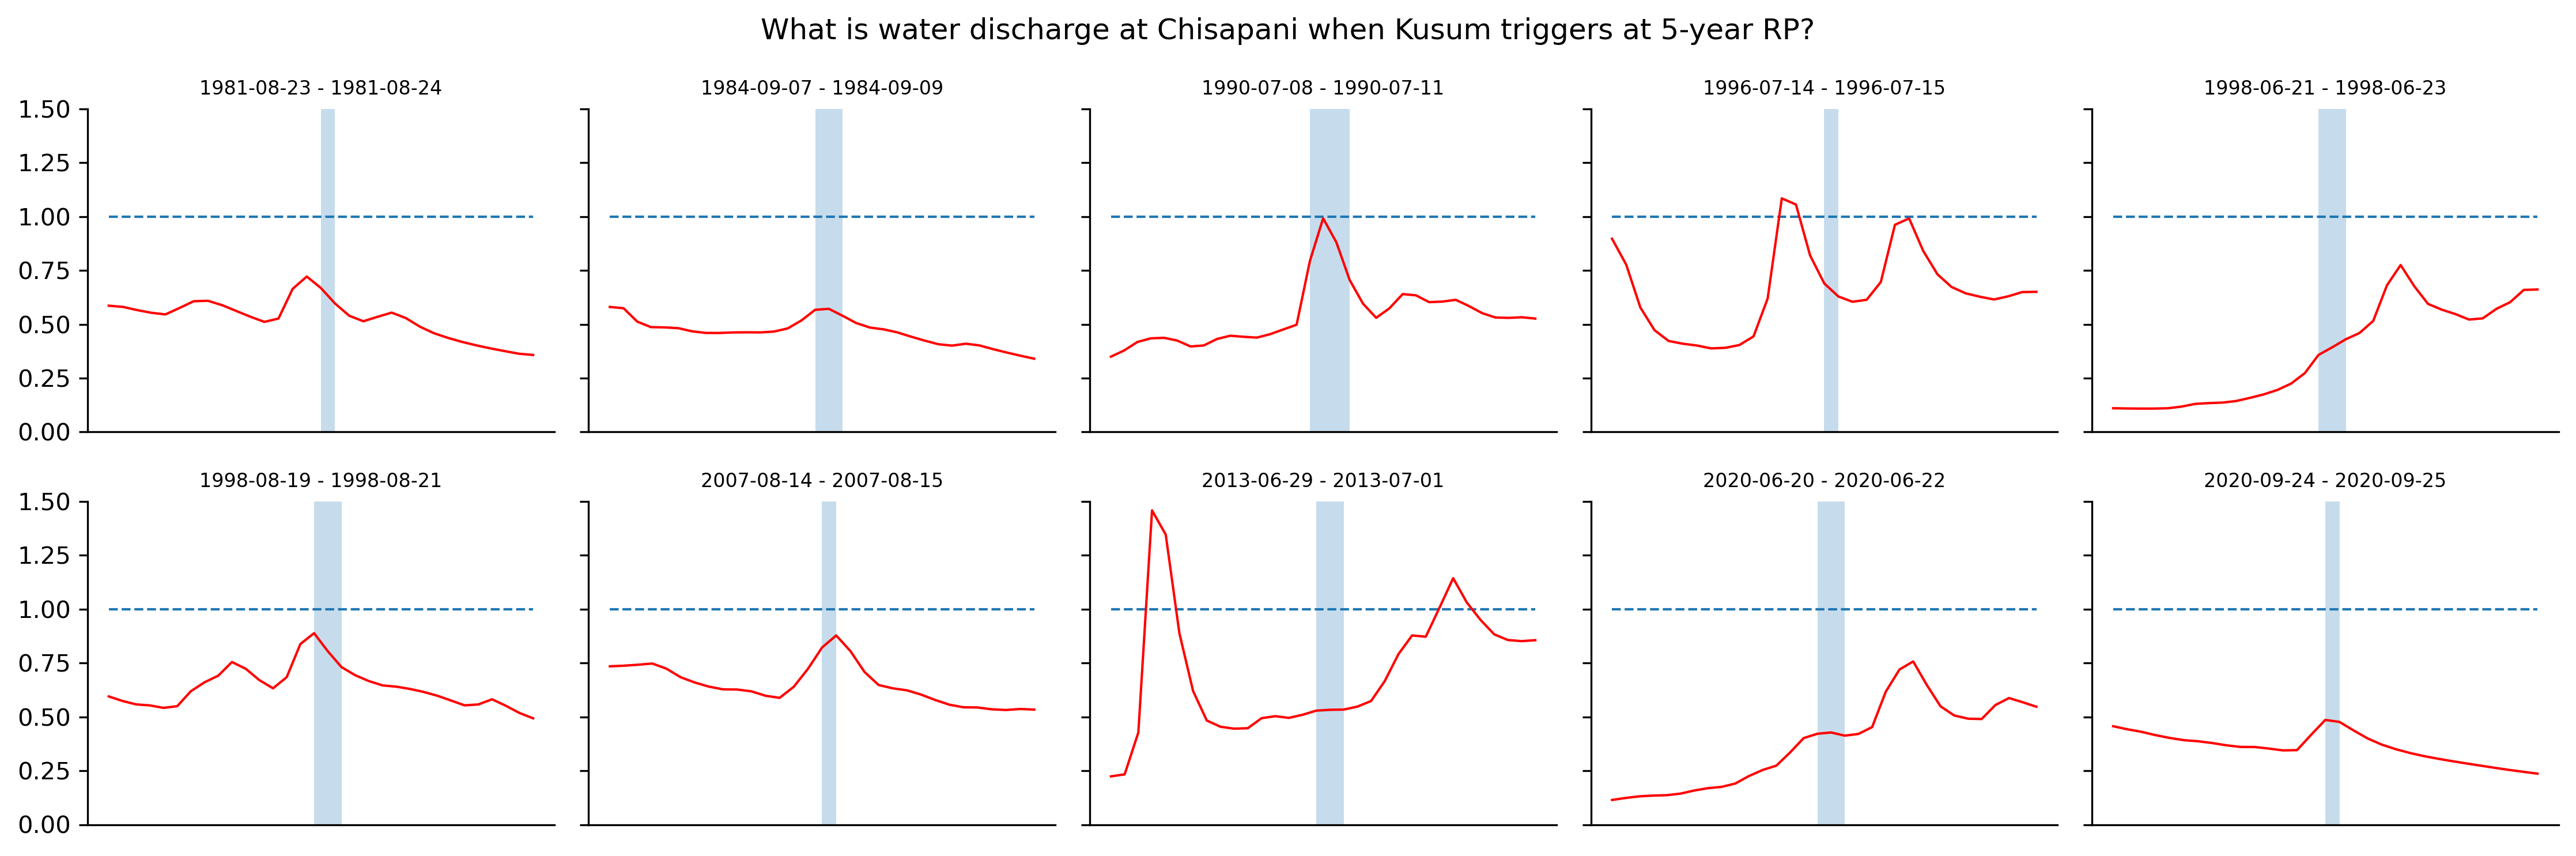

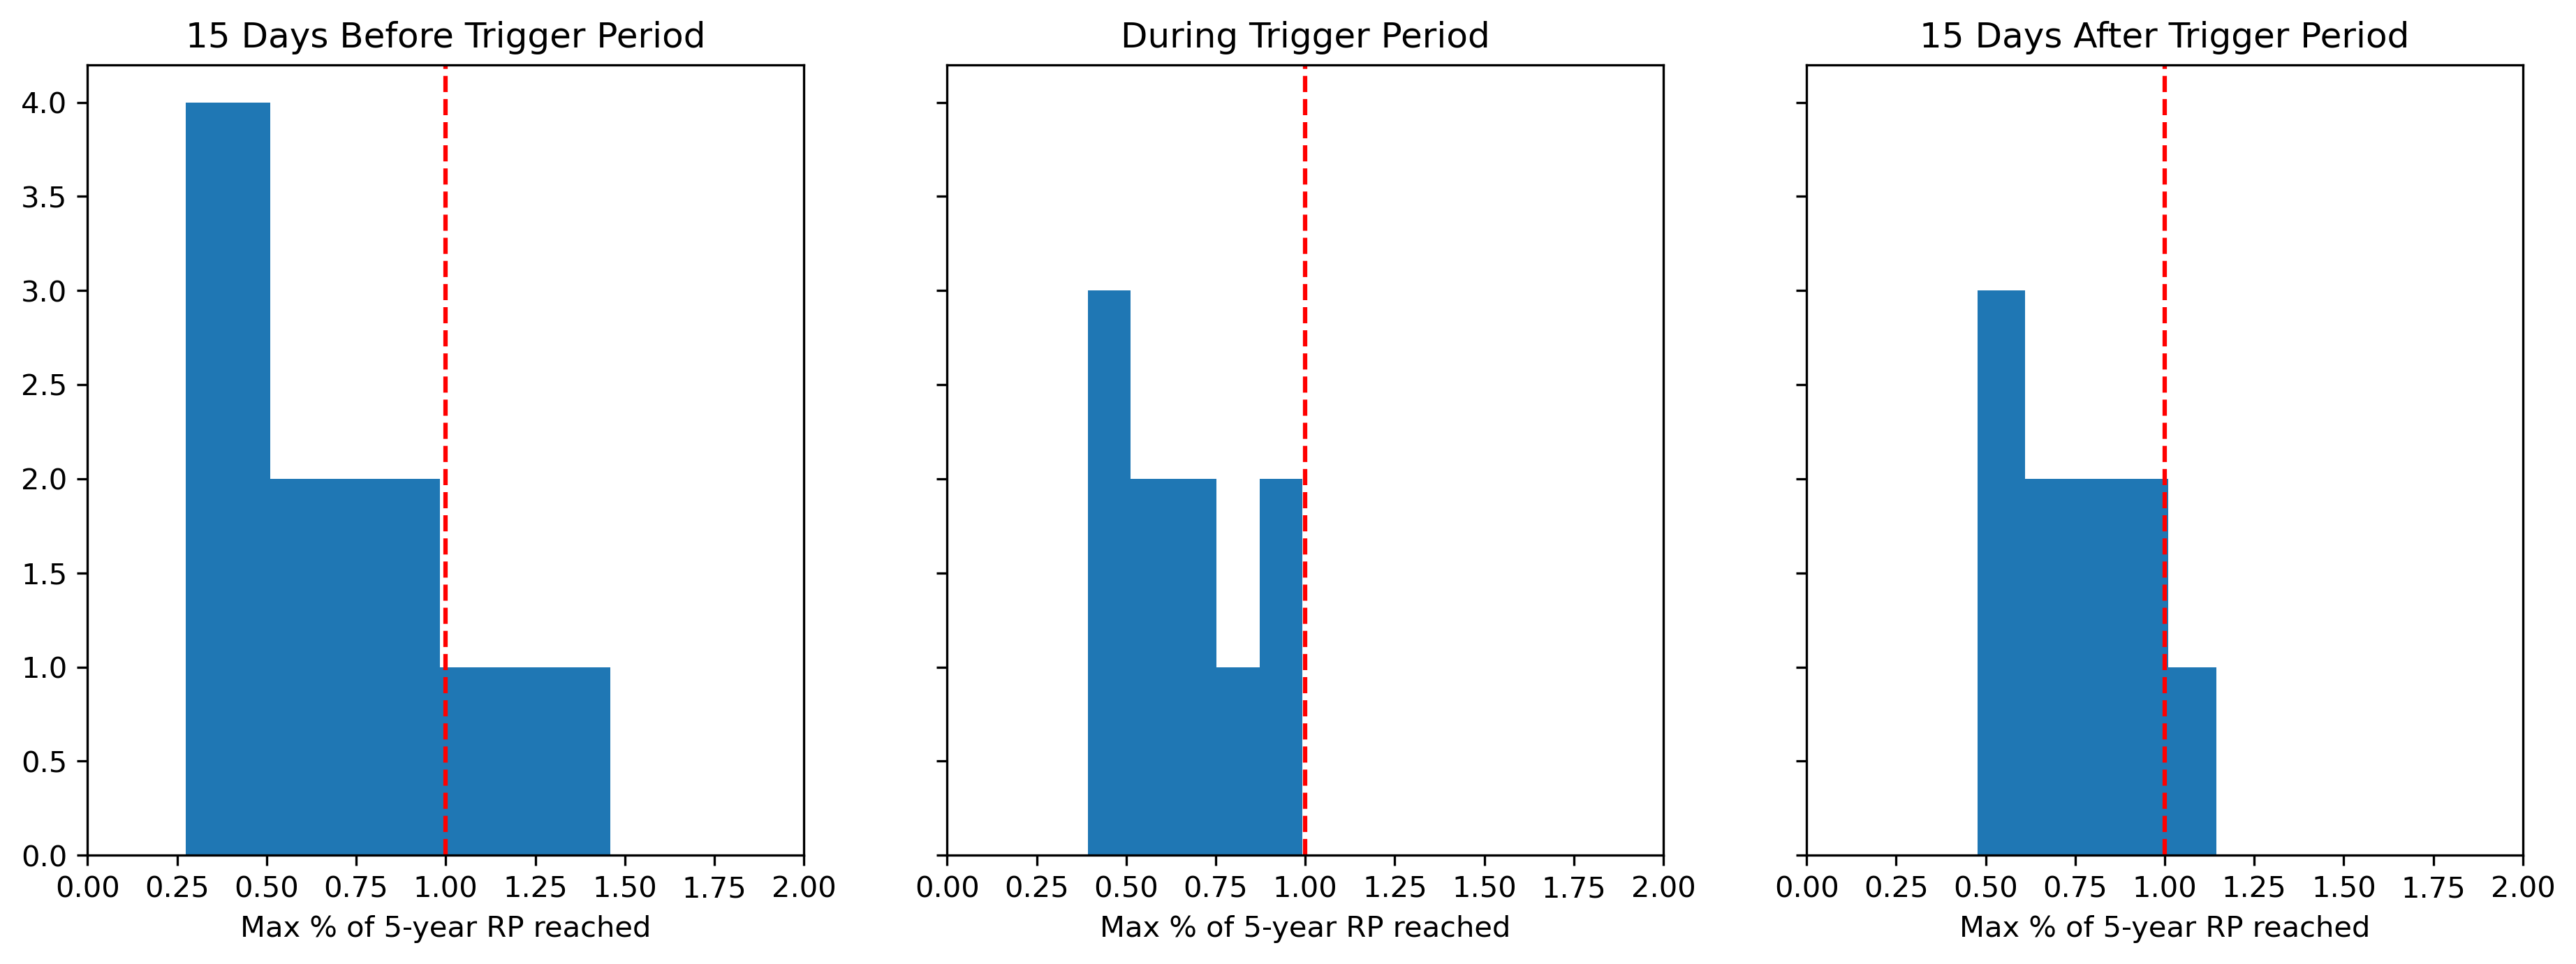

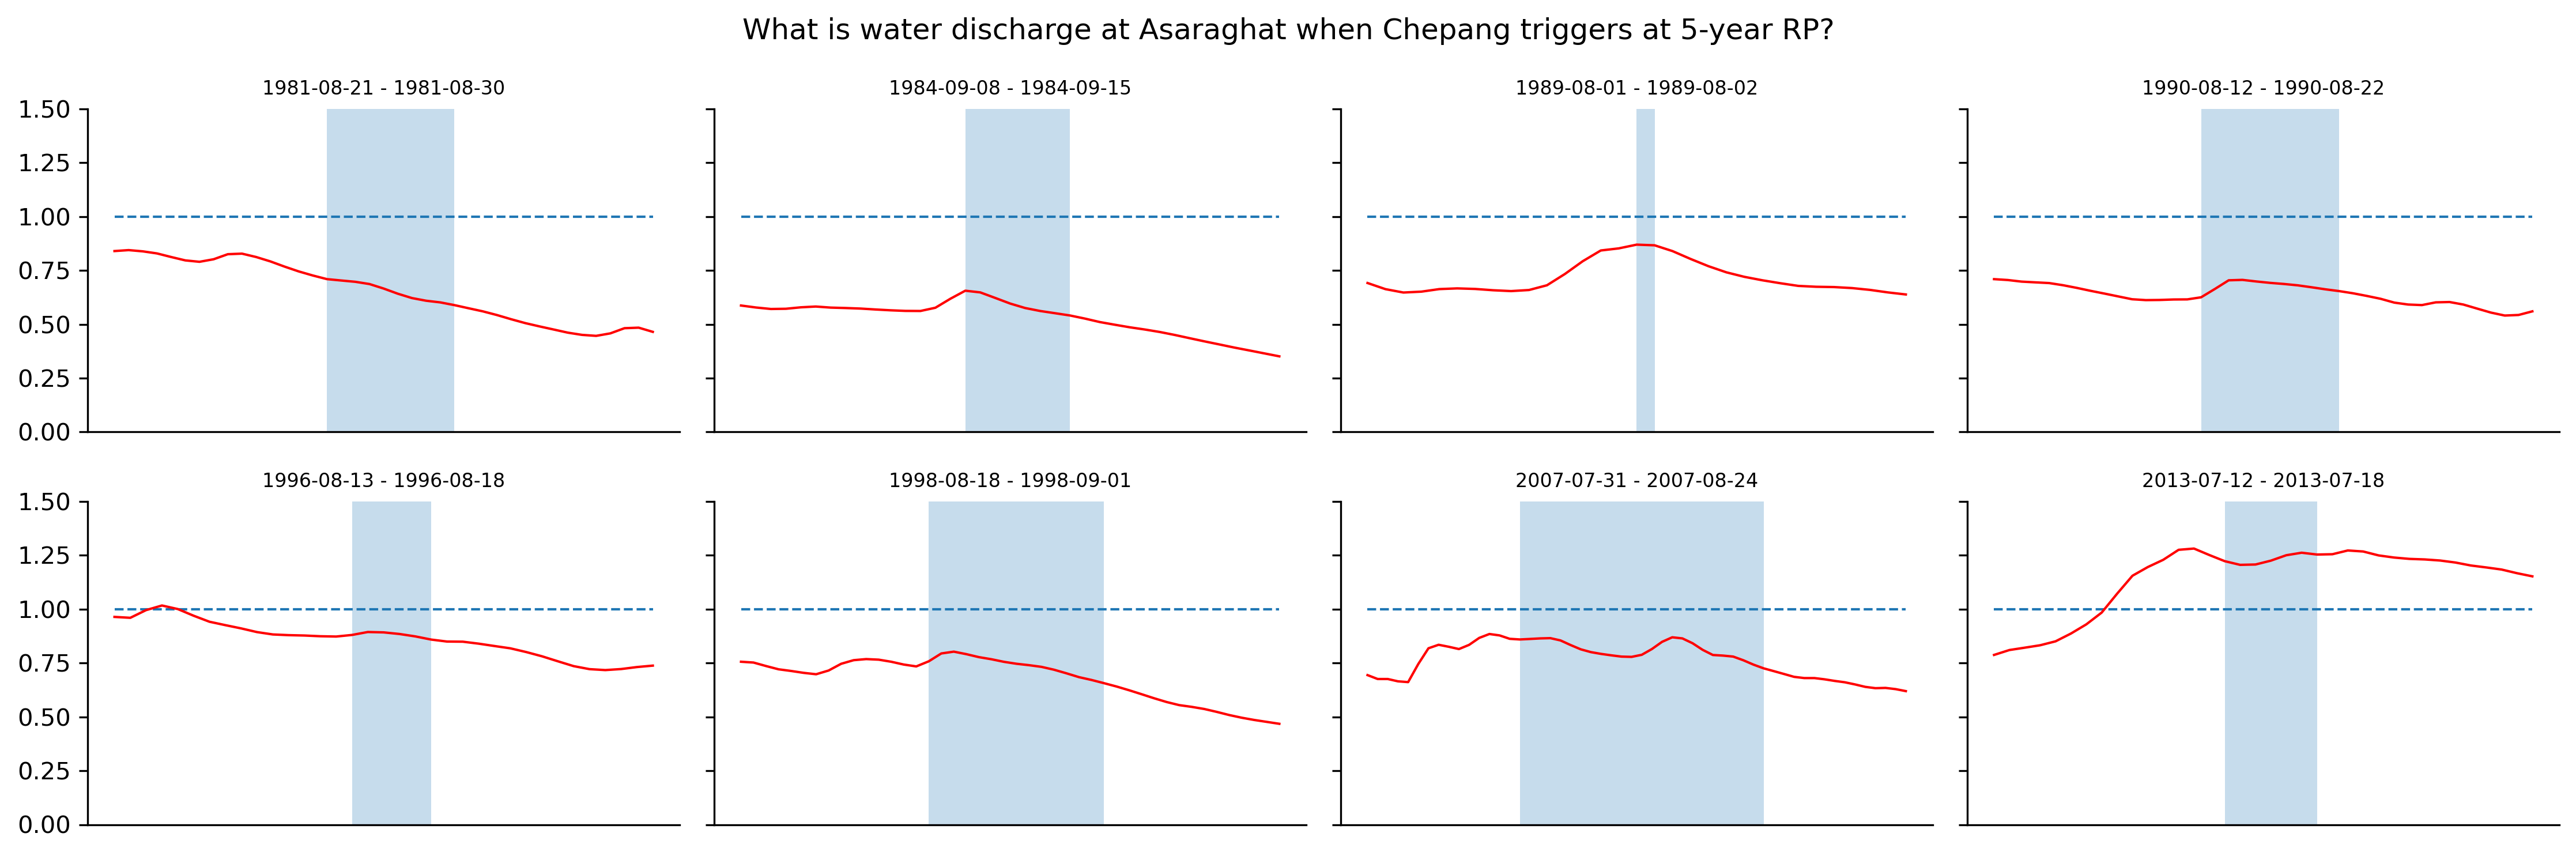

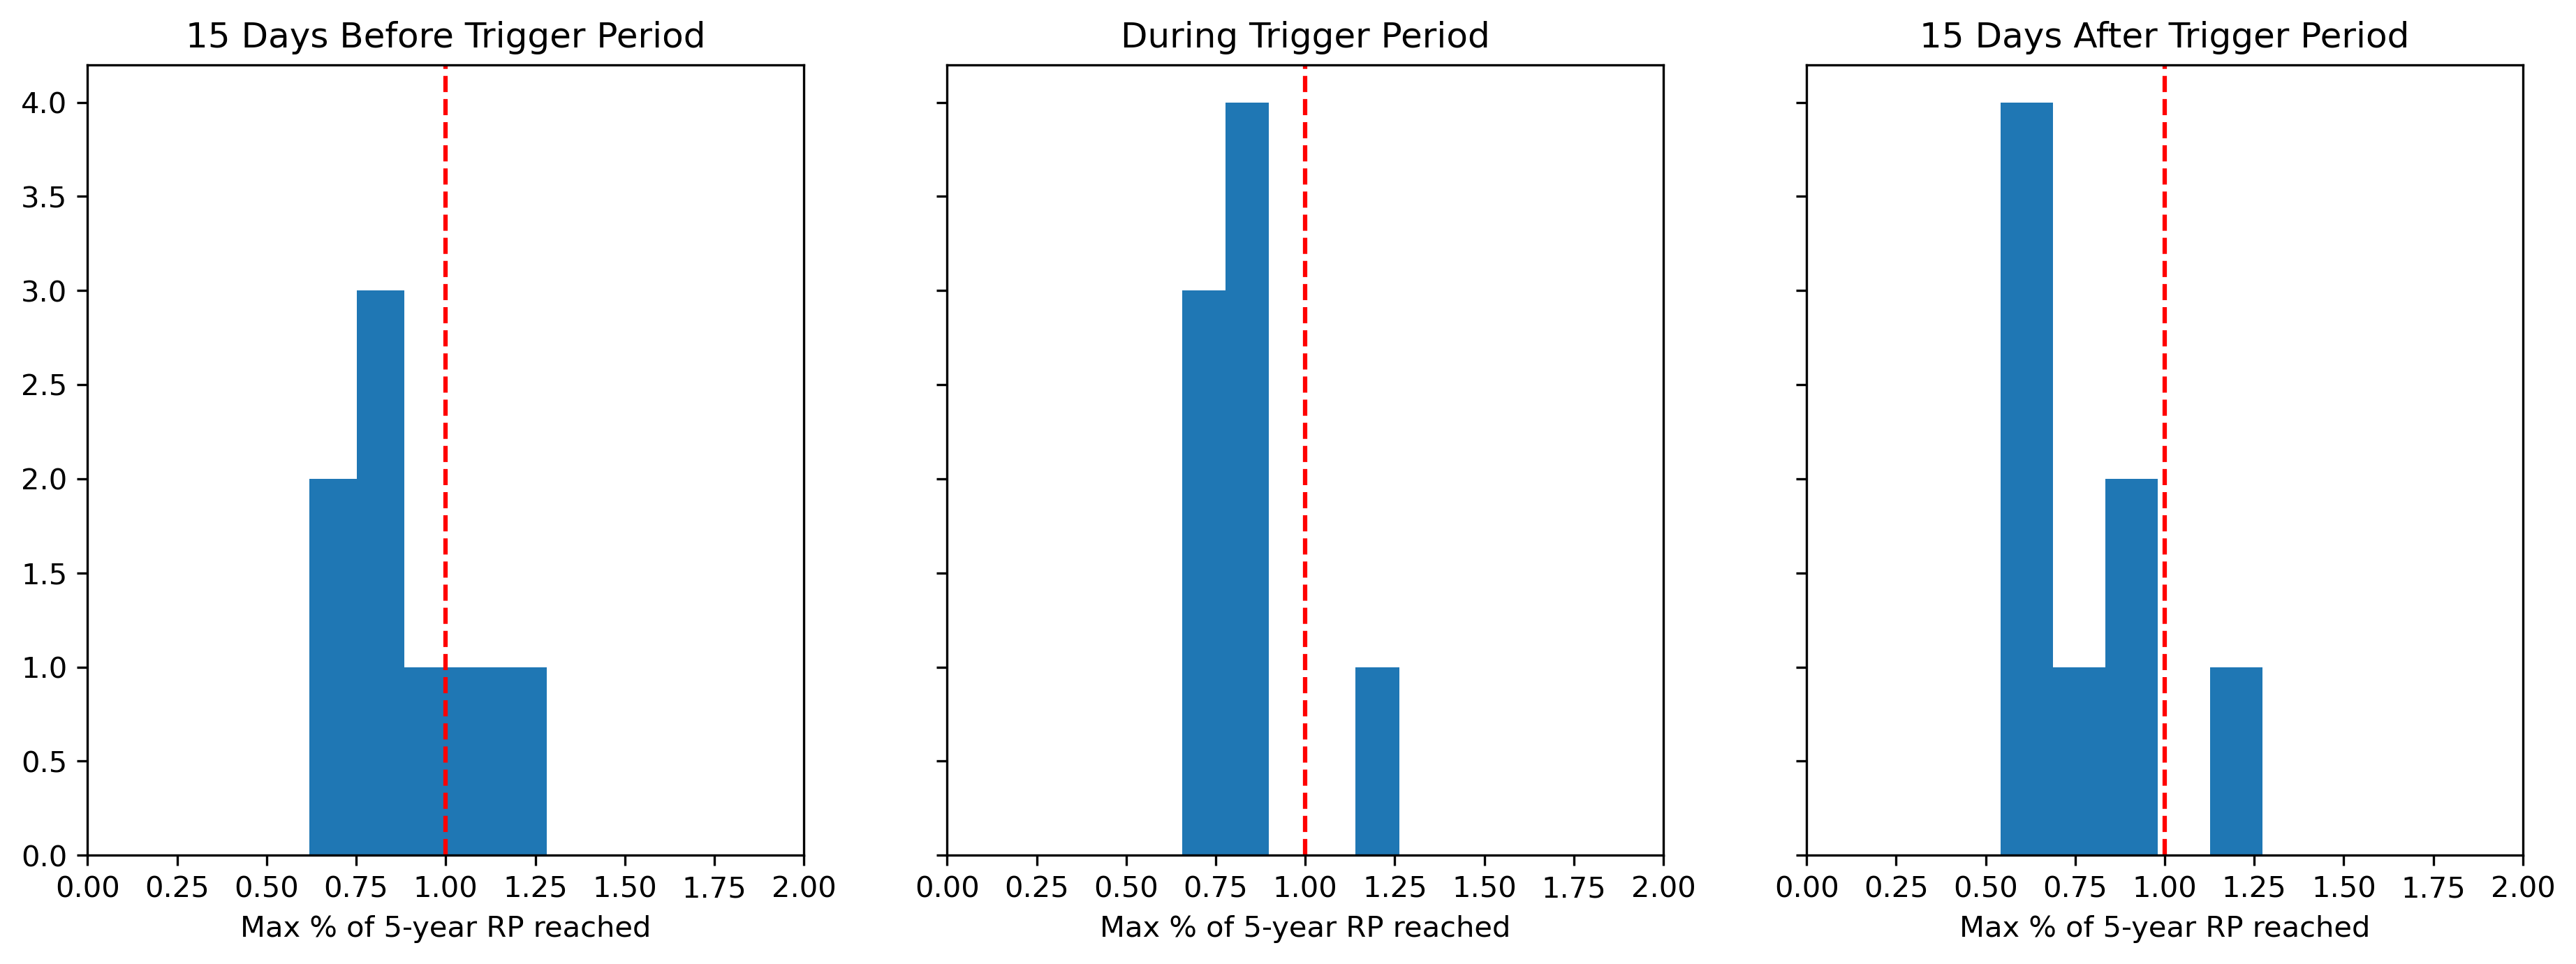

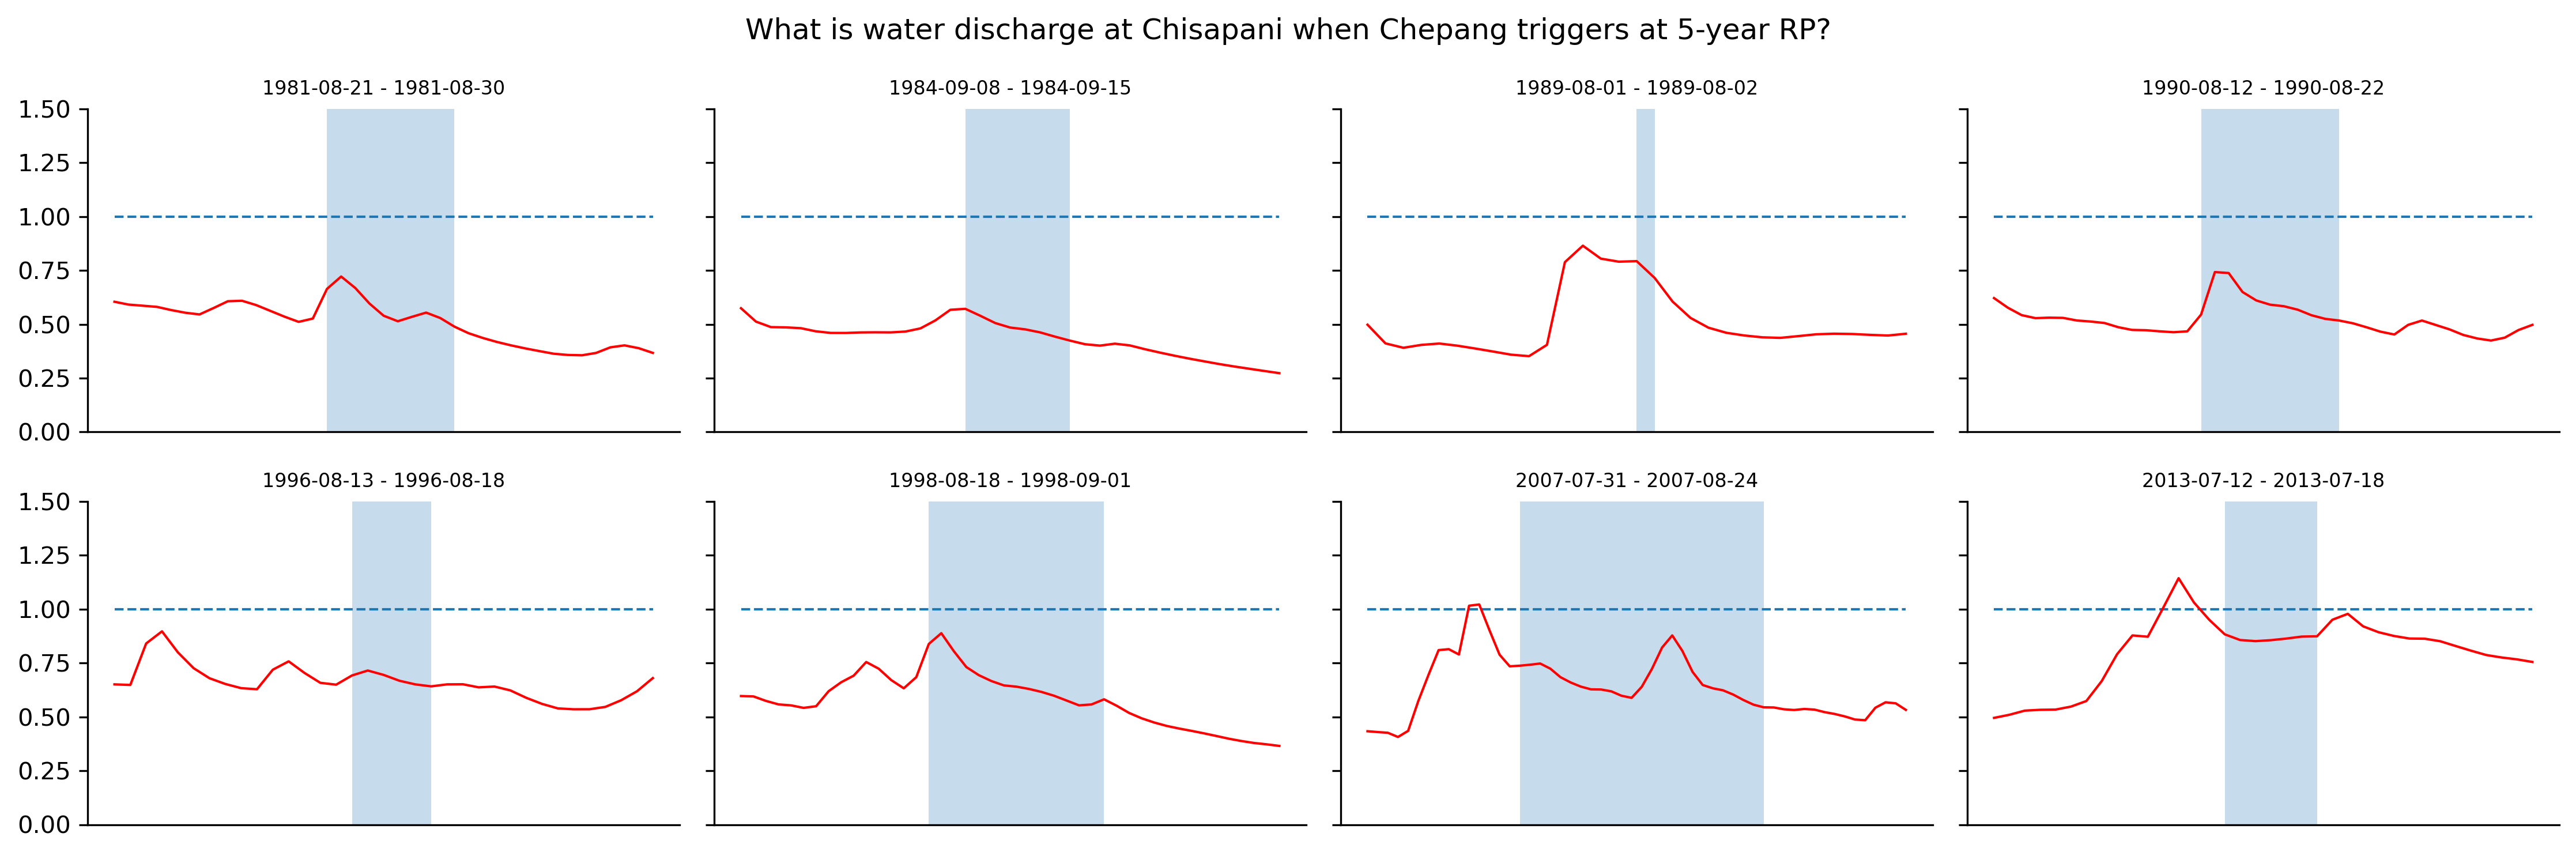

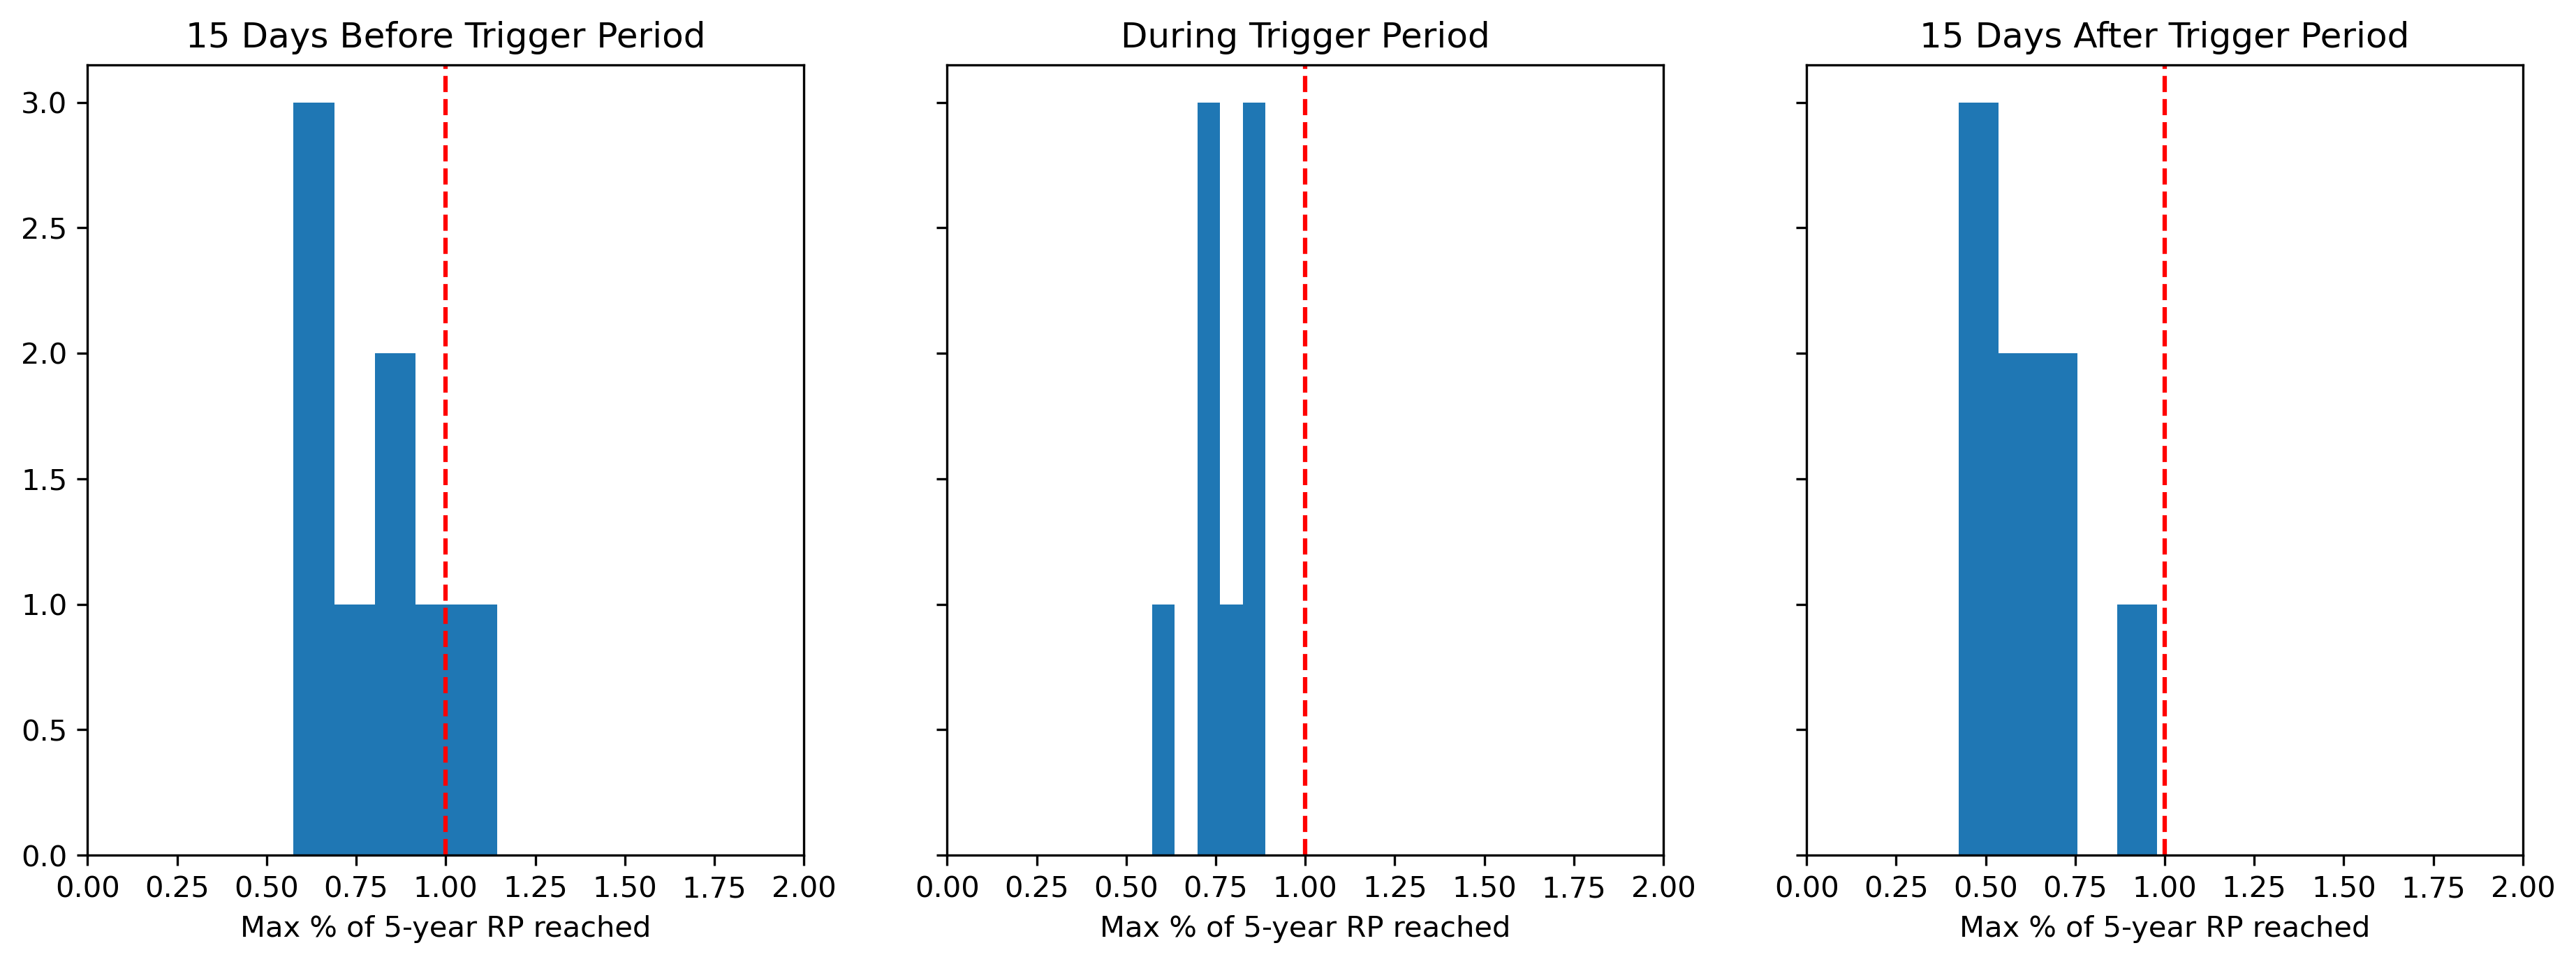

In [100]:
rp_event = 5 
rp_secondary = 5 
secondary_stations = ['Asaraghat', 'Chisapani']
primary_stations = ['Kusum', 'Chepang'] 

for station in primary_stations:
    
    #rp_val_event = int(df_return_period_glofas.loc[df_return_period_glofas['rp']==rp_event, station])
    rp_val_event = df_return_period.loc[rp_event, station]
    da_primary = ds_glofas_reanalysis[station]
        
    for station_small in secondary_stations:
        
        rp_val_secondary = df_return_period.loc[rp_secondary, station_small]  
        da_secondary = ds_glofas_reanalysis[station_small]
        
        plt_title = f'What is water discharge at {station_small} when {station} triggers at {rp_event}-year RP?'
        save_title = f'{station_small}_{station}_{rp_secondary}_{rp_event}'
        hist_title = f'Max % of {rp_secondary}-year RP reached'
        
        visualize_station_overlay(
            da_primary, 
            da_secondary, 
            rp_val_event, 
            rp_val_secondary, 
            DURATION, 
            plt_title, 
            hist_title, 
            save_title, 
            False)

#### Investigate relationship between stations with water level

In [29]:
df_wl = pd.read_csv(WL_PROCESSED_DIR / WL_OUTPUT_FILENAME, index_col='date')
df_wl['date'] = pd.to_datetime(df_wl.reset_index()['date'])
ds_wl = xr.Dataset.from_dataframe(df_wl)
df_station_info = pd.read_excel(DHM_DIR / STATION_INFO_FILENAME, index_col='station_name')

In [113]:
primary_stations = ['Chisapani']
secondary_stations = ['Kusum', 'Chepang']
thresh_event = 'warning'

# TODO: Why are there no events showing up??
# End even when the threshold is lowered it's not matching up to any data at the secondary stations

for station in primary_stations:
    
    val_event = df_station_info.at[station, f'{thresh_event}_level']
    da_primary = ds_wl[station]
        
    for station_small in secondary_stations:
        
        val_secondary = df_station_info.at[station_small, f'{thresh_event}_level']
        da_primary = ds_wl[station_small]
        
        plt_title = f'What is water discharge at {station_small} when {station} triggers at the {thresh_event} level?'
        save_title = f'{station_small}_{station}_{thresh_event}'
        hist_title = f'Max % of {thresh_event} level reached'      
        
        visualize_station_overlay(
            da_primary, 
            da_secondary, 
            val_event, 
            val_secondary, 
            DURATION, 
            plt_title, 
            hist_title, 
            save_title, 
            False)

There are no events captured at this  threshold
There are no events captured at this  threshold


In [67]:
df_wl = pd.read_csv(WL_PROCESSED_DIR / WL_OUTPUT_FILENAME, index_col='date')

ds_wl = xr.Dataset.from_dataframe(df_wl)